<a href="https://colab.research.google.com/github/jaytrey777/KMeans-Clustering-Find-K/blob/main/KMeans_Find_K_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task

The task is to perform customer segmentation using KMeans. We are interested in grouping our customers into groups based on similar characteristics. This can help the company effectively allocate marketing resources. We will use customer age, education, years of employment, income, debt, whether they defaulted, and their debt to income ratio to group them into segments.

Data source:
[Customer Segmentation with KMeans](https://github.com/Nikhil-Adithyan/Customer-Segmentation-with-K-Means)

- Use KMeans to create various customer segments.
 - Use an Elbow Plot of inertia.
 - Make a plot of Silhouette Scores.
 - Choose a K based on the results.

# Imports & Drive Mounting

In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [3]:
filename = '/content/drive/MyDrive/Colab Notebooks/03. Weeks 9-12: Advanced Machine Learning/09. Week 9: Clustering/5. Core Assignments/cust_seg.csv'
df = pd.read_csv(filename)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       850 non-null    int64  
 1   Customer Id      850 non-null    int64  
 2   Age              850 non-null    int64  
 3   Edu              850 non-null    int64  
 4   Years Employed   850 non-null    int64  
 5   Income           850 non-null    int64  
 6   Card Debt        850 non-null    float64
 7   Other Debt       850 non-null    float64
 8   Defaulted        700 non-null    float64
 9   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 66.5 KB


In [5]:
df.head()

,Unnamed: 0,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,4,5,47,1,31,253,9.308,8.908,0.0,7.2


In [6]:
df.describe()

,Unnamed: 0,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
count,850.00000,850.00000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,700.000000,850.000000
mean,424.50000,425.50000,35.029412,1.710588,8.565882,46.675294,1.576820,3.078773,0.261429,10.171647
std,245.51816,245.51816,8.041432,0.927784,6.777884,38.543054,2.125843,3.398799,0.439727,6.719441
min,0.00000,1.00000,20.000000,1.000000,0.000000,13.000000,0.012000,0.046000,0.000000,0.100000
25%,212.25000,213.25000,29.000000,1.000000,3.000000,24.000000,0.382500,1.045750,0.000000,5.100000
50%,424.50000,425.50000,34.000000,1.000000,7.000000,35.000000,0.885000,2.003000,0.000000,8.700000
75%,636.75000,637.75000,41.000000,2.000000,13.000000,55.750000,1.898500,3.903250,1.000000,13.800000
max,849.00000,850.00000,56.000000,5.000000,33.000000,446.000000,20.561000,35.197000,1.000000,41.300000


# Data Cleaning

I will drop the columns for Custome id and unnamed because they have no impact on the data we are trying to analyze.

In [7]:
df.drop(columns = ['Unnamed: 0', 'Customer Id'], inplace = True)
df.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,41,2,6,19,0.124,1.073,0.0,6.3
1,47,1,26,100,4.582,8.218,0.0,12.8
2,33,2,10,57,6.111,5.802,1.0,20.9
3,29,2,4,19,0.681,0.516,0.0,6.3
4,47,1,31,253,9.308,8.908,0.0,7.2


In [8]:
print(f' There are {df.duplicated().sum()} duplicaate rows in the data set') 

 There are 0 duplicaate rows in the data set


In [9]:
df.isna().sum()

Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
DebtIncomeRatio      0
dtype: int64

Since we dont have a way of verifying if the missing data defauted or not I am going to assume that the bank would know if a customer has defaulted on their loan and set them all to zero. 

In [10]:
df['Defaulted'].fillna(0, inplace = True)
df.isna().sum()

Age                0
Edu                0
Years Employed     0
Income             0
Card Debt          0
Other Debt         0
Defaulted          0
DebtIncomeRatio    0
dtype: int64

# KMeans Customer Segments

## Instantiate Scaler

In [11]:
scaler = StandardScaler() #Instantiate Scaler
scaled_df = scaler.fit_transform(df) #fit it to the dataframs

## Elbow Method

In [12]:
inertia = [] #storage for inertias

for k in range(2,16): # Loop through k values 2-15 and store inertia results
    kmeans_elbow = KMeans(n_clusters=k, random_state = 42)  
    kmeans_elbow.fit(scaled_df)  
    inertia.append(kmeans_elbow.inertia_)

### Plot Results

Text(0, 0.5, 'inertia')

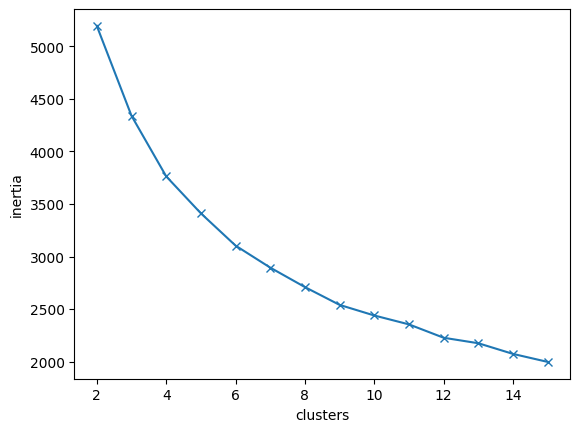

In [13]:
plt.plot(range(2,16), inertia, marker = 'x')
plt.xlabel('clusters')
plt.ylabel('inertia')

## Silhouette Scores

In [14]:
silhouettes = [] # storage
for i in range(2, 16): # Loop through values 2-15
  kmeans_silhouette = KMeans(n_clusters = i, random_state = 42)
  kmeans_silhouette.fit(scaled_df)
  silhouettes.append(silhouette_score(scaled_df, kmeans_silhouette.labels_))

### Plot Results

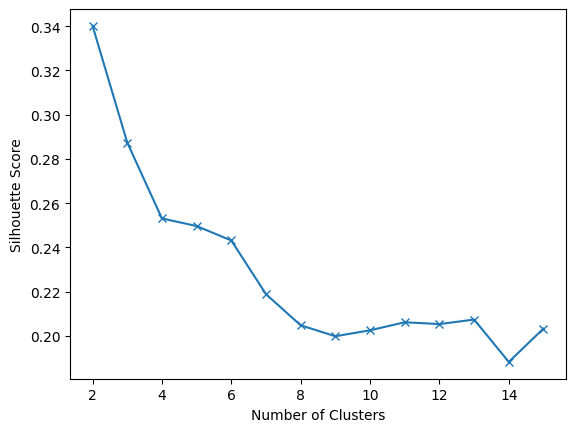

In [15]:
plt.plot(range(2, 16), silhouettes, marker = 'x')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

## KMeans Scores

### 9 Clusters

In [16]:
kmeans9 = KMeans(n_clusters = 9, random_state = 42)
kmeans9.fit(scaled_df)
silhouette_score(scaled_df, kmeans9.labels_)

0.1998253049929825

### 14 Clusters

In [18]:
kmeans11 = KMeans(n_clusters = 14, random_state = 42)
kmeans11.fit(scaled_df)
silhouette_score(scaled_df, kmeans11.labels_)

0.18821561950114288

## Analysis

Based on this data I would most likely make 9 clusters.  There are 850 rows in the data set. This would be as small as I would feel comfortable to go considering the clusters are less than 100 items per cluster.